In [1]:
import sys

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from branch_and_bound import branch_and_bound
from twice_around_the_tree import twice_around_the_tree
from christofides import christofides_algorithm
from drop_vertex import drop_vertices

def euclidean_distance(coord1, coord2):
    """Calcula a distância euclidiana entre dois pontos."""
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def create_tsp_graph_from_file(file_path):
    """
    Cria um grafo NetworkX para o problema TSP a partir de um arquivo de coordenadas.

    Args:
    file_path (str): Caminho para o arquivo contendo os dados do TSP.

    Returns:
    networkx.Graph: Grafo representando o problema TSP.
    """
    G = nx.Graph()

    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Encontra a seção onde as coordenadas dos nós começam
    start = lines.index("NODE_COORD_SECTION\n") + 1
    end = lines.index("EOF\n", start)
    coord_lines = lines[start:end]

    coords = {}
    for line in coord_lines:
        parts = line.split()
        coords[parts[0]] = (float(parts[1]), float(parts[2]))

    # Adiciona os nós com suas coordenadas
    for node, coord in coords.items():
        G.add_node(node, coord=coord)

    # Adiciona as arestas com pesos baseados na distância euclidiana
    for node1, coord1 in coords.items():
        for node2, coord2 in coords.items():
            if node1 != node2:
                distance = euclidean_distance(coord1, coord2)
                G.add_edge(node1, node2, weight=distance)

    return G

In [6]:
file_path = 'data/berlin52.tsp'

tsp_graph = create_tsp_graph_from_file(file_path)

costs_tw = []
paths_tw = []

costs_chr = []
paths_chr = []

costs = []
paths = []

for i in range(10):
    graph = tsp_graph.copy()
    graph = drop_vertices(graph, n=(52-10), seed=i)

    cost_tw, path_tw = twice_around_the_tree(graph)
    costs_tw.append(cost_tw)
    paths_tw.append(path_tw)

    cost_chr, path_chr = christofides_algorithm(graph)
    costs_chr.append(cost_chr)
    paths_chr.append(path_chr)

    cost, path = branch_and_bound(graph)
    costs.append(cost)
    paths.append(path)

In [46]:
data = {'twice_around_the_tree': costs_tw, 'christofides': costs_chr, 'branch_and_bound': costs}
df = pd.DataFrame(data=data)
df.head()

,twice_around_the_tree,christofides,branch_and_bound
0,4437.253128,4019.920699,4019.920699
1,2590.202721,2590.202721,2590.202721
2,4804.629949,4470.723483,4470.723483
3,3475.023345,3475.023345,3475.023345
4,4438.319904,3990.831749,3990.831749


In [47]:
df['error_tw'] = df['twice_around_the_tree'] - df['branch_and_bound']
df['error_chr'] = df['christofides'] - df['branch_and_bound']

df['relative_error_tw'] = df['error_tw'] / df['branch_and_bound']
df['relative_error_chr'] = df['error_chr'] / df['branch_and_bound']

In [48]:
df.head(10)

,twice_around_the_tree,christofides,branch_and_bound,error_tw,error_chr,relative_error_tw,relative_error_chr
0,4437.253128,4019.920699,4019.920699,417.332429,0.00000,0.103816,0.000000
1,2590.202721,2590.202721,2590.202721,0.000000,0.00000,0.000000,0.000000
2,4804.629949,4470.723483,4470.723483,333.906466,0.00000,0.074687,0.000000
3,3475.023345,3475.023345,3475.023345,0.000000,0.00000,0.000000,0.000000
4,4438.319904,3990.831749,3990.831749,447.488155,0.00000,0.112129,0.000000
5,3754.995403,3754.995403,3746.366183,8.629220,8.62922,0.002303,0.002303
6,3959.460163,3381.129513,3381.129513,578.330650,0.00000,0.171047,0.000000
7,3254.729074,3152.634374,3152.634374,102.094701,0.00000,0.032384,0.000000
8,3906.263686,3504.060468,3504.060468,402.203218,0.00000,0.114782,0.000000
9,2701.580795,2430.067385,2430.067385,271.513410,0.00000,0.111731,0.000000


<AxesSubplot:>

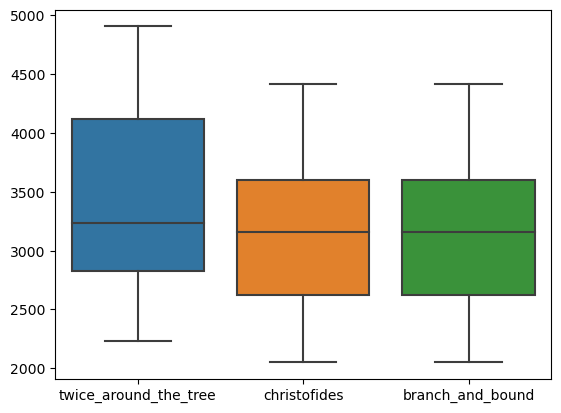

In [14]:
sns.boxplot(data=df[['twice_around_the_tree', 'christofides', 'branch_and_bound']])

<AxesSubplot:>

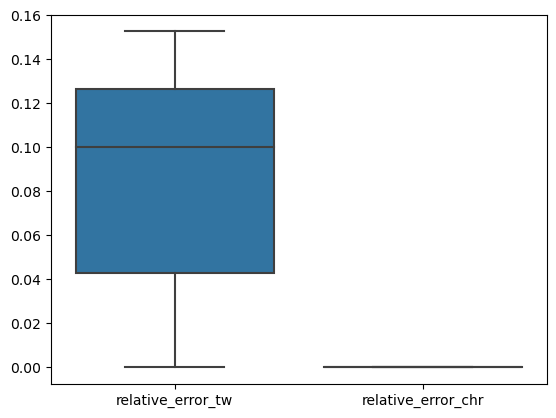

In [19]:
sns.boxplot(data=df[['relative_error_tw', 'relative_error_chr']])

<AxesSubplot:>

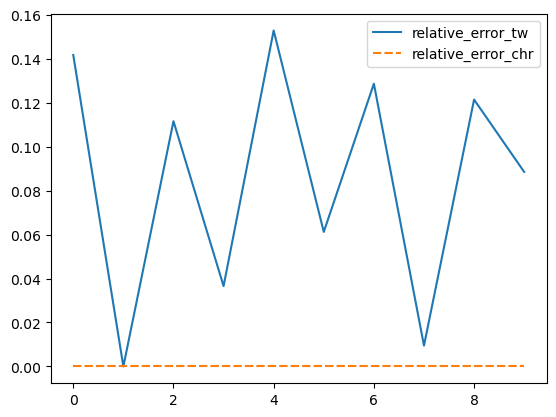

In [20]:
sns.lineplot(data=df[['relative_error_tw', 'relative_error_chr']])

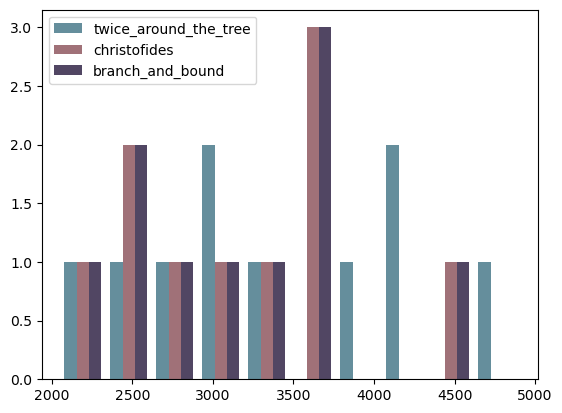

In [41]:
plt.hist([df['twice_around_the_tree'], df['christofides'], df['branch_and_bound']], 
         label=['twice_around_the_tree', 'christofides', 'branch_and_bound'], 
         color=['#658E9C', '#A07178', '#514663'])
plt.legend()


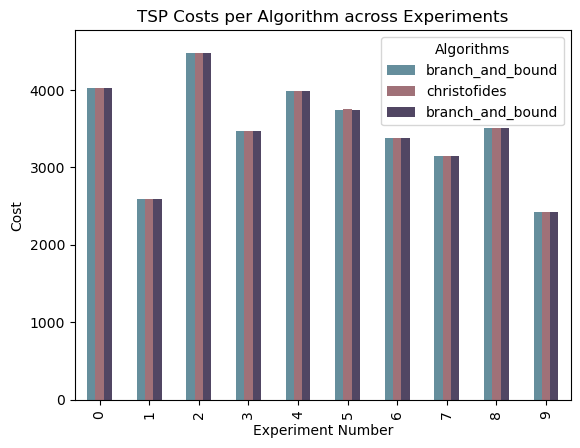

In [84]:
# Plotting

ax = df[['branch_and_bound', 'christofides', 'branch_and_bound']].plot(kind='bar', color=['#658E9C', '#A07178', '#514663'])
ax.set_xlabel("Experiment Number")
ax.set_ylabel("Cost")
ax.set_title("TSP Costs per Algorithm across Experiments")
plt.legend(title="Algorithms")

ax.set_ylim(0, max(df['branch_and_bound']) + 300)  # Adjust the upper limit as needed


plt.show()
